<a href="https://colab.research.google.com/github/tawhidwasik08/-tawhidwasik08-Multiclass-Text-Classifiction-with-Tensorflow-RoBERTa/blob/main/Multiclass_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Libraries

In [ ]:
# drive access
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

!pip install transformers
from transformers import RobertaTokenizer, TFAutoModel, AdamWeightDecay 

import tensorflow as tf

####Load Dataset


**Dataset Link :** https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news

**Modification of dataset** : Change categorical text values to numerical values

In [2]:
def modify_df(dataset):
    df = dataset.copy()

    df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == 'negative' else x)
    df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'neutral' else x)
    df['sentiment'] = df['sentiment'].apply(lambda x: 2 if x == 'positive' else x)

    return df 


def df_info(df,name):
    negative = df[df.sentiment == 0].shape[0]
    neutral = df[df.sentiment == 1].shape[0]
    positive = df[df.sentiment == 2].shape[0]    

    print(f"\n{name} -----> shape : {df.shape}")
    print(f"{name} -----> negative: {negative}, neutral: {neutral}, positive: {positive}\n")

    return None  

In [3]:
root = "drive/MyDrive/Tensorflow Projects/Multiclass Sentiment Classification on Financial News/"
df = pd.read_csv(root + "kaggle_dataset.csv", header=None, sep=',', names=['sentiment', 'text'], engine='python')

print(df.head())

df = modify_df(df)
df_info(df,"original")

  sentiment                                               text
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...

original -----> shape : (4846, 2)
original -----> negative:604, neutral: 2879, positive: 1363



The dataset is highly imbalanced. Very few negatives. More neutral than positives.

**Split Dataset**: Split dataset into 3 sets : Train(90%), valid(5%), test(5%)

In [4]:
train, valid_test = train_test_split(df, test_size = 0.1, shuffle=True)
valid, test = train_test_split(valid_test, test_size = 0.5, shuffle=True)

df_info(train, "train")
df_info(valid, "valid")
df_info(test, "test")


x_train = train[["text"]]
y_train = train[["sentiment"]]

x_valid = valid[["text"]]
y_valid = valid[["sentiment"]]


x_test = test[["text"]]
y_test = test[["sentiment"]]


train -----> shape : (4361, 2)
train -----> negative:545, neutral: 2599, positive: 1217


valid -----> shape : (242, 2)
valid -----> negative:33, neutral: 134, positive: 75


test -----> shape : (243, 2)
test -----> negative:26, neutral: 146, positive: 71



Finding out how much max length of the sequences(texts) are.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


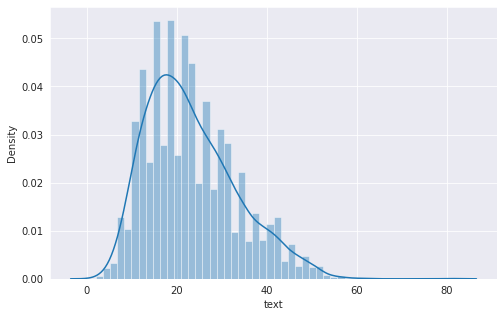

In [5]:
seqlen = x_train["text"].apply(lambda x: len(x.split()))

sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
sns.distplot(seqlen)

#### Preprocessings

Some common preprocessing for the texts.

In [6]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def preprocess_text(text):
    def clean_text(x):
        x = str(x)
        for punct in puncts:
            if punct in x:
                x = x.replace(punct, f' {punct} ')
        return x

    def clean_numbers(x):
        if bool(re.search(r'\d', x)):
            x = re.sub('[0-9]{5,}', '#####', x)
            x = re.sub('[0-9]{4}', '####', x)
            x = re.sub('[0-9]{3}', '###', x)
            x = re.sub('[0-9]{2}', '##', x)
        return x
    
    text = text.lower()
    text = clean_text(text)
    text = clean_numbers(text)

    return text


In [7]:
def preprocess(df, text_col_name):

    # lower and clean text
    df[text_col_name] = df[text_col_name].apply(lambda x: preprocess_text(x))

    # fill up the missing values
    df[text_col_name] = df[text_col_name].fillna("_##_")

    return df

In [8]:
x_train = preprocess(x_train.copy(), "text")
x_valid = preprocess(x_valid.copy(), "text")

print(x_train.head())

                                                   text
1072  professional and consumer applications include...
3445  vacon recently announced plans to build its no...
3794  the company had net sales of eur ## . 8 millio...
4198  huhtamaki  ' s rigid plastic consumer goods op...
1764  the goal is to secure the company  ' s profita...


####Tokenization with RoBERTa Tokenizer


In [9]:
SEQ_LEN = 80

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [10]:
def tokenize(df):
    input_ids =  []
    attention_masks =  []
    
    for i, text in enumerate(df["text"]):
        tokens = tokenizer.encode_plus(text, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')   
         
        input_ids.append(np.asarray(tokens["input_ids"]).reshape(SEQ_LEN,))
        attention_masks.append(np.asarray(tokens["attention_mask"]).reshape(SEQ_LEN,))

    return (np.asarray(input_ids), np.asarray(attention_masks))

train_input_ids, train_attention_masks = tokenize(x_train)
valid_input_ids, valid_attention_masks = tokenize(x_valid)

print(train_input_ids[0])

[    0 23878     8  2267  2975   680  1081 14461  1437  2156  1437  1081
  1078  1437  2156  1437   882     8 32209  1052  1437  2156  1437     8
  3440  6779  1437   479  1437     2     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]


#### One hot encoding for the labels

In [11]:
def one_encode_labels(df):
    sentiment_values = set(df["sentiment"].values)
    labels = []
    for index, row in df.iterrows():
        label = np.zeros((len(sentiment_values)))
        label[row["sentiment"]] = 1 
        labels.append(label)
    labels = np.asarray(labels)
    return labels

In [12]:
y_train = one_encode_labels(y_train)
y_valid = one_encode_labels(y_valid)

print(y_train[0])

[0. 1. 0.]


#### Model Defining


In [13]:
roberta = TFAutoModel.from_pretrained("roberta-base")

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [14]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = roberta(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(128)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(768)(X)
X = tf.keras.layers.Activation("relu")(X)
X = tf.keras.layers.Dense(768)(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

#### Compile and training of model

In [15]:
optimizer = AdamWeightDecay(2e-03, beta_1=0.8, beta_2=0.9, weight_decay_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [16]:
history = model.fit((train_input_ids, train_attention_masks),y_train, validation_data=((valid_input_ids,valid_attention_masks), y_valid), epochs=10, batch_size=32)

Epoch 1/10
137/137 [==============================] - 35s 163ms/step - loss: 1.2114 - accuracy: 0.5625 - val_loss: 0.8711 - val_accuracy: 0.5950
Epoch 2/10
137/137 [==============================] - 19s 141ms/step - loss: 0.7375 - accuracy: 0.6671 - val_loss: 0.8922 - val_accuracy: 0.6281
Epoch 3/10
137/137 [==============================] - 19s 140ms/step - loss: 0.6098 - accuracy: 0.7356 - val_loss: 0.7069 - val_accuracy: 0.6942
Epoch 4/10
137/137 [==============================] - 19s 140ms/step - loss: 0.4835 - accuracy: 0.8143 - val_loss: 0.5658 - val_accuracy: 0.8223
Epoch 5/10
137/137 [==============================] - 19s 140ms/step - loss: 0.4167 - accuracy: 0.8269 - val_loss: 1.1285 - val_accuracy: 0.7810
Epoch 6/10
137/137 [==============================] - 19s 140ms/step - loss: 0.3725 - accuracy: 0.8529 - val_loss: 0.6884 - val_accuracy: 0.8347
Epoch 7/10
137/137 [==============================] - 19s 141ms/step - loss: 0.3550 - accuracy: 0.8631 - val_loss: 1.0243 - val_ac

#### Prediction and classification result

In [17]:
tokenizer =  RobertaTokenizer.from_pretrained("roberta-base")

# predictions need to go through same preprocessings
def prep_data(text):
    text = preprocess_text(text)

    tokens = tokenizer.encode_plus(text, max_length=80,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')

    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

def predict(text):
    in_tensor = prep_data(text)
    probs = model.predict(in_tensor)[0]
    return (np.argmax(probs))

In [ ]:
predictions = np.asarray(x_test["text"].apply(lambda x: predict(x)))
test_vals = np.asarray(y_test["sentiment"])

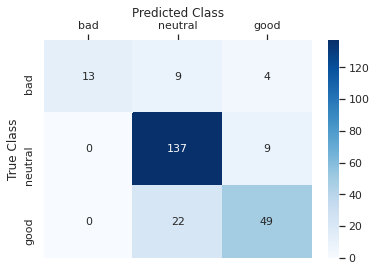

              precision    recall  f1-score   support

         bad     1.0000    0.5000    0.6667        26
     neutral     0.8155    0.9384    0.8726       146
        good     0.7903    0.6901    0.7368        71

    accuracy                         0.8189       243
   macro avg     0.8686    0.7095    0.7587       243
weighted avg     0.8279    0.8189    0.8109       243



In [19]:
confusion = confusion_matrix(test_vals, predictions)

# plot confusion matrix
sns.set(font_scale=1.0)
labels = ["bad", "neutral", "good"]
ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 11}, fmt='d', vmin = 0, cmap='Blues', yticklabels=labels, xticklabels=labels)
ax.set_xlabel('Predicted Class')   
ax.set_ylabel('True Class')   
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.show()

# print classification report
report = classification_report(test_vals, predictions, digits = 4, output_dict=False, target_names=["bad", "neutral", "good"],)
print(report)